In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

Load and normalize columns

In [2]:
df = pd.read_csv('data/raw_data.csv')

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
)

# Drop empty columns
empty_cols = df.columns[df.isna().all()].tolist()
df = df.drop(columns=empty_cols)

Fix employment sector missing values

In [3]:
missing_sector = df[df['employment_sector'].isna()]['employment_status'].value_counts()

df.loc[
    df['employment_sector'].isna() & (df['employment_status'] == 'unemployed'),
    'employment_sector'
] = 'unemployed'

df['employment_sector'] = df['employment_sector'].fillna('unknown')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   user_id                     100000 non-null  object
 1   applications                100000 non-null  int64 
 2   reason                      100000 non-null  object
 3   loan_amount                 100000 non-null  int64 
 4   fico_score                  100000 non-null  int64 
 5   fico_score_group            100000 non-null  object
 6   employment_status           100000 non-null  object
 7   employment_sector           100000 non-null  object
 8   monthly_gross_income        100000 non-null  int64 
 9   monthly_housing_payment     100000 non-null  int64 
 10  ever_bankrupt_or_foreclose  100000 non-null  int64 
 11  lender                      100000 non-null  object
 12  approved                    100000 non-null  int64 
 13  bounty                      10

Check distributions of all variables

In [4]:
for col in df.columns:
    print(f"\n==== {col} ====")
    print(df[col].value_counts(normalize=True).head())


==== user_id ====
user_id
fffe836d-3176-4766-81c0-8812d1d9a0a6    0.00001
55b2b0c3-cf5d-4cd7-865e-5f6b58ebd255    0.00001
55a9467c-f2df-4f23-afbb-0fcaea6661fa    0.00001
55aa83ac-8071-4a3e-a680-089840709797    0.00001
55aacd4f-2771-4d5f-b06f-cf5dbdb1413d    0.00001
Name: proportion, dtype: float64

==== applications ====
applications
1    1.0
Name: proportion, dtype: float64

==== reason ====
reason
credit_card_refinancing    0.28328
home_renovation            0.19843
debt_consolidation         0.12882
unexpected_expense         0.11703
medical_bill               0.10627
Name: proportion, dtype: float64

==== loan_amount ====
loan_amount
30000    0.16903
20000    0.15191
10000    0.13803
40000    0.10114
80000    0.09597
Name: proportion, dtype: float64

==== fico_score ====
fico_score
562    0.00837
554    0.00690
556    0.00675
559    0.00661
561    0.00654
Name: proportion, dtype: float64

==== fico_score_group ====
fico_score_group
fair         0.36475
poor         0.28475
good   

Validate income and monthly housing reasonableness of inputs

In [5]:
df[['monthly_gross_income', 'monthly_housing_payment']].describe()

,monthly_gross_income,monthly_housing_payment
count,100000.000000,100000.000000
mean,5871.899350,1649.693970
std,2882.939639,623.443127
min,2000.000000,300.000000
25%,3704.000000,1229.000000
50%,5172.500000,1665.000000
75%,7631.000000,2046.000000
max,19997.000000,3300.000000


Checks how many rows have an income to housing ratio above 100%, 200%, and 500%

In [6]:
df['housing_to_income_ratio'] = (
    df['monthly_housing_payment'] / df['monthly_gross_income']
)

df['housing_to_income_ratio'].describe()

print((df['housing_to_income_ratio'] > 1).sum(), "over 100% of income")
print((df['housing_to_income_ratio'] > 2).sum(), "over 200%")
print((df['housing_to_income_ratio'] > 5).sum(), "over 500%")


997 over 100% of income
0 over 200%
0 over 500%


Converts FICO group column into nominal categorical data

In [7]:
fico_order = ['poor','fair','good','very_good','excellent']
df['fico_score_group'] = pd.Categorical(df['fico_score_group'], categories=fico_order, ordered=True)

Creates a bar plot the displays approval rate based on FICO group

/var/folders/q2/f9q8wy0j2nj5tgwhdxr7q28h0000gn/T/ipykernel_32820/3149155061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_by_fico = df.groupby('fico_score_group')['approved'].mean().reset_index()
/var/folders/q2/f9q8wy0j2nj5tgwhdxr7q28h0000gn/T/ipykernel_32820/3149155061.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


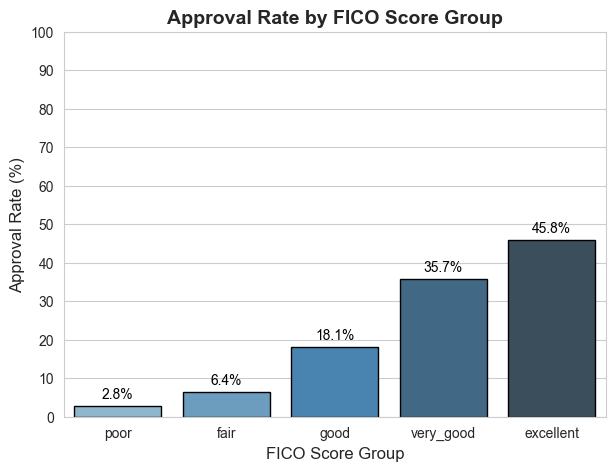

In [8]:
approval_by_fico = df.groupby('fico_score_group')['approved'].mean().reset_index()
approval_by_fico['approved_pct'] = approval_by_fico['approved'] * 100
approval_by_fico
approval_by_fico['approved_pct'] = approval_by_fico['approved'] * 100

sns.set_style("whitegrid")  
plt.figure(figsize=(7,5))

# Bar plot
bar_plot = sns.barplot(
    x='fico_score_group',
    y='approved_pct',
    data=approval_by_fico,
    palette='Blues_d',  
    edgecolor='black'   
)

# Titles and labels
plt.title('Approval Rate by FICO Score Group', fontsize=14, weight='bold')
plt.xlabel('FICO Score Group', fontsize=12)
plt.ylabel('Approval Rate (%)', fontsize=12)

# Format y-axis as percentage
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))  # ticks every 10%

# Display percentage on top of bars
for index, row in approval_by_fico.iterrows():
    bar_plot.text(
        index, row['approved_pct'] + 2,  
        f"{row['approved_pct']:.1f}%", 
        color='black', 
        ha='center', 
        fontsize=10
    )

Creates a line plot that shows approval rate by loan amount

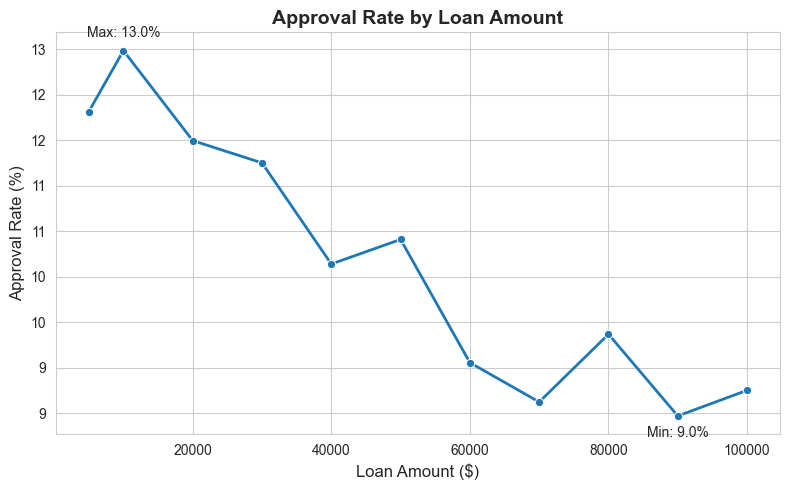

In [9]:

approval_by_loan = df.groupby('loan_amount')['approved'].mean().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

# Line plot
sns.lineplot(
    data=approval_by_loan,
    x='loan_amount',
    y='approved',
    marker='o',
    color='#1f77b4',
    linewidth=2
)

# Titles and labels
plt.title("Approval Rate by Loan Amount", fontsize=14, weight='bold')
plt.xlabel("Loan Amount ($)", fontsize=12)
plt.ylabel("Approval Rate (%)", fontsize=12)

# Format y-axis as plain numbers (0–100) without percent signs
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: int(y*100)))

# Annotate key points
max_idx = approval_by_loan['approved'].idxmax()
min_idx = approval_by_loan['approved'].idxmin()
plt.annotate(f"Max: {approval_by_loan.loc[max_idx, 'approved']*100:.1f}%",
             (approval_by_loan.loc[max_idx, 'loan_amount'], approval_by_loan.loc[max_idx, 'approved']),
             textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"Min: {approval_by_loan.loc[min_idx, 'approved']*100:.1f}%",
             (approval_by_loan.loc[min_idx, 'loan_amount'], approval_by_loan.loc[min_idx, 'approved']),
             textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()


Creates a barplot that shows approval rates separated by lenders

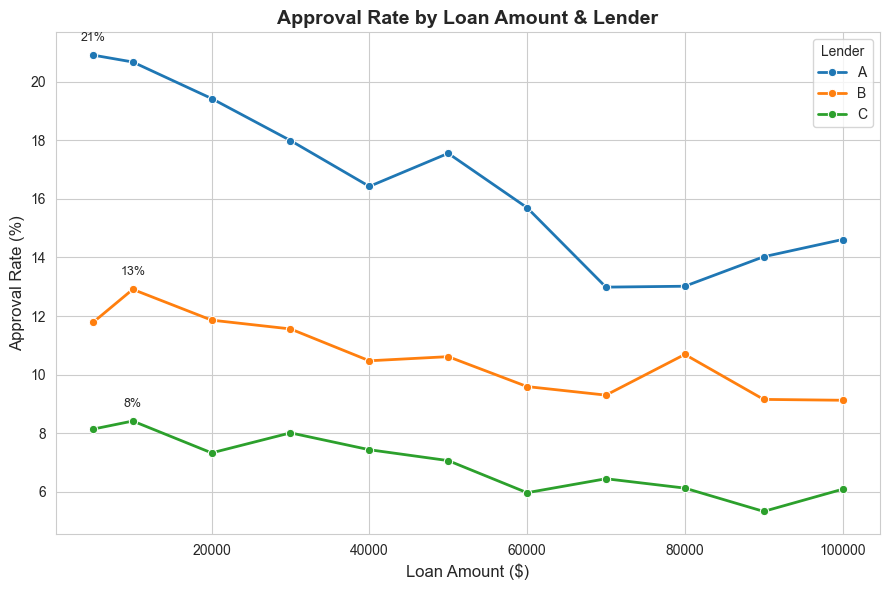

In [10]:
approval_by_lender_loan = (
    df.groupby(['lender', 'loan_amount'])['approved']
      .mean()
      .reset_index()
)

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(9,6))

# Line plot 
sns.lineplot(
    data=approval_by_lender_loan,
    x='loan_amount',
    y='approved',
    hue='lender',
    marker='o',
    linewidth=2,
    palette={'A':'#1f77b4', 'B':'#ff7f0e', 'C':'#2ca02c'}  
)

# Titles and labels
plt.title("Approval Rate by Loan Amount & Lender", fontsize=14, weight='bold')
plt.xlabel("Loan Amount ($)", fontsize=12)
plt.ylabel("Approval Rate (%)", fontsize=12)

# Format y-axis as plain numbers without percent signs
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: int(y*100)))

# Annotate key points for each lender
for lender in ['A','B','C']:
    subset = approval_by_lender_loan[approval_by_lender_loan['lender'] == lender]
    max_idx = subset['approved'].idxmax()
    plt.annotate(f"{subset.loc[max_idx,'approved']*100:.0f}%",
                 (subset.loc[max_idx,'loan_amount'], subset.loc[max_idx,'approved']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.legend(title='Lender')
plt.tight_layout()
plt.show()

Shows correlation of numerical variables to the variable of interest (approval)

In [11]:
df.corr(numeric_only=True)['approved'].sort_values(ascending=False)


approved                      1.000000
bounty                        0.959721
fico_score                    0.269673
monthly_gross_income          0.171829
monthly_housing_payment      -0.027644
ever_bankrupt_or_foreclose   -0.035311
loan_amount                  -0.040170
housing_to_income_ratio      -0.121246
applications                       NaN
Name: approved, dtype: float64

Shows proportion of categorical variables that contribute to the variable of interest (approval)

In [12]:
print("Approval by FICO Group:")
print(df.groupby('fico_score_group')['approved'].mean(), "\n")

print("Approval by Employment Status:")
print(df.groupby('employment_status')['approved'].mean(), "\n")

print("Approval by Reason:")
print(df.groupby('reason')['approved'].mean(), "\n")

print("Approval by Employment Sector:")
print(df.groupby('employment_sector')['approved'].mean())


Approval by FICO Group:
fico_score_group
poor         0.027849
fair         0.064373
good         0.180620
very_good    0.356723
excellent    0.458410
Name: approved, dtype: float64 

Approval by Employment Status:
employment_status
full_time     0.120724
part_time     0.081282
unemployed    0.054948
Name: approved, dtype: float64 

Approval by Reason:
reason
credit_card_refinancing    0.110597
debt_consolidation         0.114889
home_renovation            0.109409
major_purchase             0.108430
medical_bill               0.105486
other                      0.109439
unexpected_expense         0.107921
wedding                    0.108291
Name: approved, dtype: float64 

Approval by Employment Sector:
employment_sector
communication_services    0.095718
consumer_discretionary    0.084207
consumer_staples          0.096835
energy                    0.106003
financials                0.132369
health_care               0.119729
industrials               0.117476
information_technology 

/var/folders/q2/f9q8wy0j2nj5tgwhdxr7q28h0000gn/T/ipykernel_32820/1571153925.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('fico_score_group')['approved'].mean(), "\n")


Segmentation by FICO group

In [13]:
segment_col = 'fico_score_group'

approval_matrix = (
    df.groupby([segment_col, 'lender'])['approved']
      .mean()
      .reset_index()
      .pivot(index=segment_col, columns='lender', values='approved')
)

approval_matrix


/var/folders/q2/f9q8wy0j2nj5tgwhdxr7q28h0000gn/T/ipykernel_32820/3480101944.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([segment_col, 'lender'])['approved']


lender,A,B,C
fico_score_group,,,
poor,0.075524,0.026274,0.000000
fair,0.130186,0.065689,0.015419
good,0.260110,0.179660,0.135946
very_good,0.491803,0.358491,0.298364
excellent,0.546196,0.443697,0.434921


Converts approval rates into expected revenue per FICO group

In [14]:
bounty = {'A':150, 'B':250, 'C':350}

revenue_matrix = approval_matrix.copy()
for lender in ['A','B','C']:
    revenue_matrix[lender] = revenue_matrix[lender] * bounty[lender]

revenue_matrix

lender,A,B,C
fico_score_group,,,
poor,11.328588,6.568433,0.000000
fair,19.527897,16.422145,5.396553
good,39.016544,44.915042,47.581081
very_good,73.770492,89.622642,104.427524
excellent,81.929348,110.924370,152.222222


Find the optimal lender segment

In [15]:
optimal_lender = revenue_matrix.idxmax(axis=1)
optimal_lender

fico_score_group
poor         A
fair         A
good         C
very_good    C
excellent    C
dtype: object

Create bar chart that visualizes the increase in average revenue per application after optimization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Current revenue ---
df['current_revenue'] = df['approved'] * df['bounty']

# --- Step 2: Compute optimal revenue per FICO group ---
# Determine expected revenue per lender for each FICO group
approval_matrix = df.groupby(['fico_score_group', 'lender'])['approved'].mean().unstack()
bounty = {'A': 150, 'B': 250, 'C': 350}

# Expected revenue = approval rate * bounty
expected_revenue = approval_matrix.copy()
for lender in expected_revenue.columns:
    expected_revenue[lender] *= bounty[lender]

# Optimal lender per FICO group
optimal_lender = expected_revenue.idxmax(axis=1)
optimal_bounty = optimal_lender.map(bounty)
optimal_approval_rate = optimal_lender.map(lambda x: approval_matrix[x])

# Compute optimal revenue per FICO group
optimal_revenue = optimal_approval_rate * optimal_bounty

# --- Step 3: Prepare dataframe for plotting ---
revenue_summary = pd.DataFrame({
    'fico_score_group': optimal_lender.index,
    'Current': df.groupby('fico_score_group')['current_revenue'].mean().values,
    'Optimal': optimal_revenue.values
}).melt(id_vars='fico_score_group', var_name='Scenario', value_name='Revenue')

# --- Step 4: Plot grouped bar chart ---
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

palette = {'Current':'#1f77b4', 'Optimal':'#ff7f0e'}

bar_plot = sns.barplot(
    x='fico_score_group',
    y='Revenue',
    hue='Scenario',
    data=revenue_summary,
    palette=palette,
    edgecolor='black'
)

# Titles and labels
plt.title('Average Revenue per Application by FICO Group', fontsize=14, weight='bold')
plt.xlabel('FICO Score Group', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)

# Annotate bars
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f"${height:,.2f}",
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=9)

plt.ylim(0, revenue_summary['Revenue'].max() * 1.15)
plt.legend(title='Scenario', fontsize=10)
sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()


NameError: name 'revenue_melted' is not defined

Calculate the current and optimized average RPA

In [ ]:
df['current_revenue'] = df['approved'] * df['bounty']
df['optimal_revenue'] = df['optimal_approval_rate'] * df['optimal_bounty']
df['current_revenue'].sum()
df['optimal_revenue'].sum()
df[['current_revenue','optimal_revenue']].mean()